# Dataset and Benchmark creation with `Polaris`
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <07_01_polaris_adme-fang-1_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib
import numpy as np

import datamol as dm

# polaris benchmark
from polaris.benchmark import MultiTaskBenchmarkSpecification

# polaris hub
from polaris.utils.types import HubOwner

# utils
root = pathlib.Path("__file__").absolute().parents[3]
os.chdir(root)
sys.path.insert(0, str(root))
from utils.docs_utils import load_readme

In [2]:
# Get the owner and organization

org = "novartis"
data_name = "CYP"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"

dataset_name = "novartis_cyp3a4-v1"

owner = HubOwner(slug=org, type="organization")
owner

HubOwner(slug='novartis', external_id=None, type='organization')

In [5]:
BENCHMARK_DIR = f"{gcp_root}/benchmarks"
DATASET_JSON = "gs://polaris-public/polaris-recipes/org-novartis/CYP/datasets/novartis_cyp3a4-v1/dataset.json"

FIGURE_DIR = f"{gcp_root}/figures"

## Load existing dataset object



In [6]:
# Load the saved Dataset
from polaris.dataset import Dataset

dataset = Dataset.from_json(DATASET_JSON)

In [7]:
dataset

{
  "name": "novartis_cyp3a4-v1",
  "description": "CYP3A4 Time-Dependent Inhibition data released by Novartis",
  "tags": [
    "ADME"
  ],
  "user_attributes": {
    "year": "2024"
  },
  "owner": "novartis",
  "polaris_version": "dev",
  "default_adapters": {},
  "zarr_root_path": null,
  "md5sum": "dcefee6bdae2a0c8224ea14a54e8b7ad",
  "readme": "",
  "annotations": {
    "MOL_smiles": {
      "is_pointer": false,
      "modality": "MOLECULE",
      "description": "Molecule SMILES string",
      "user_attributes": {},
      "dtype": "object"
    },
    "log_kobs": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Log unit of TDI CYP3A4 inactivation.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "CLS_log_kobs": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Three-class binning on TDI CYP3A4 inactivation  0.01 and 0.025.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "pIC50_CYP3A4": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Reversible CYP3A4 inhibition pIC50 values.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "pIC50_CYP2C9": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Reversible CYP2C9 inhibition pIC50 values.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "pIC50_CYP2D6": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Reversible CYP2D6 inhibition pIC50 values.",
      "user_attributes": {},
      "dtype": "float64"
    },
    "split": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": "Train and test splitting from the original publication doi.org/10.1021/acs.chemrestox.3c00305",
      "user_attributes": {},
      "dtype": "object"
    }
  },
  "source": "https://opendata.ncats.nih.gov/adme/data",
  "license": "CC-BY-4.0",
  "curation_reference": "https://github.com/polaris-hub/polaris-recipes/org-Polaris/org-Novartis/CYP/00_CYP3A4_data_processing.ipynb",
  "cache_dir": "/Users/lu.zhu/Library/Caches/polaris/datasets/novartis_cyp3a4-v1/dcefee6bdae2a0c8224ea14a54e8b7ad",
  "artifact_id": "novartis/novartis-cyp3a4-v1",
  "n_rows": 16740,
  "n_columns": 7
}

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

In [8]:
dataset.columns

['MOL_smiles',
 'log_kobs',
 'CLS_log_kobs',
 'pIC50_CYP3A4',
 'pIC50_CYP2C9',
 'pIC50_CYP2D6',
 'split']

In [9]:
mol_col = "MOL_smiles"
data_cols = [
    "log_kobs",
    "pIC50_CYP3A4",
    "pIC50_CYP2C9",
    "pIC50_CYP2D6",
]

## Create a Benchmark as in published paper
The train/test sets are pre-defined in `doi.org/10.1021/acs.chemrestox.3c00305`

In [10]:
train_split = dataset.table.query("split == 'train'").index.values
test_split = dataset.table.query("split == 'test'").index.values

### Check distribution of train/test set in the chemical space

  0%|          | 0/16740 [00:00<?, ?it/s]

'https://storage.googleapis.com/polaris-public/polaris-recipes/org-novartis/CYP/figures/paper_split_chemspace.png'

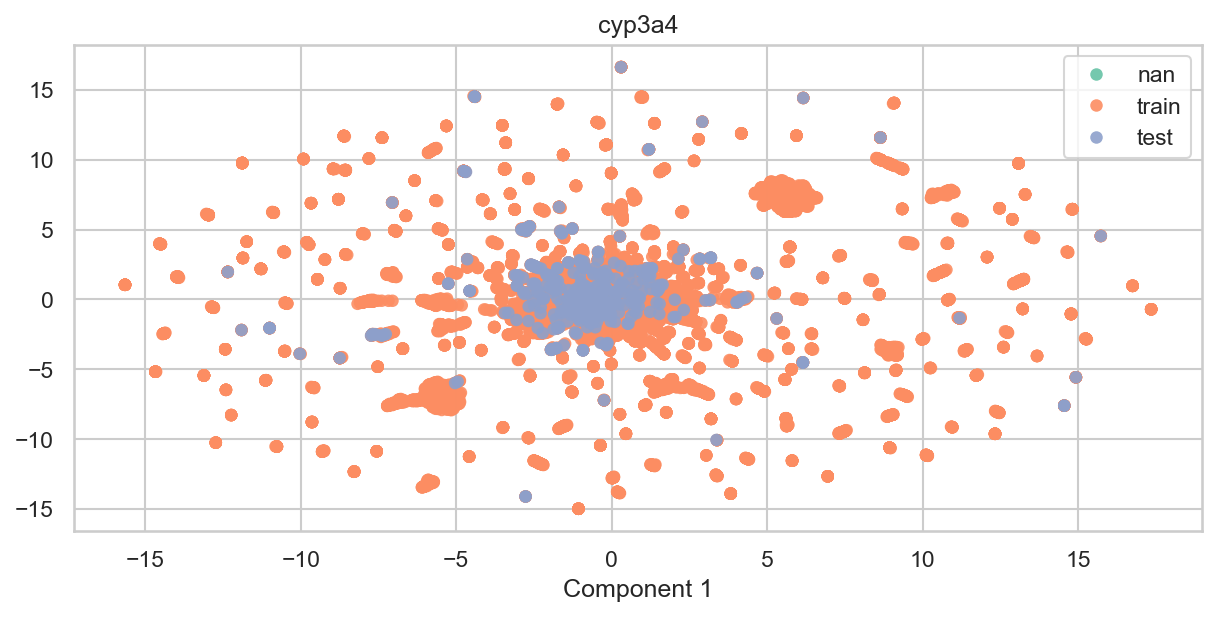

In [11]:
from utils.docs_utils import visualize_split_chemspace

fig = visualize_split_chemspace(
    mols=dataset.table[mol_col].to_list(),
    train_test_dict={"cyp3a4": (train_split, test_split)},
)

# export the figure to remote path
from utils.auroris_utils import save_image

save_image(fig, dm.fs.join(FIGURE_DIR, f"paper_split_chemspace.png"))

## Multitask regression task and evaluate on log Kobs three classes

In [12]:
benchmark_name = "adme-novartis-cyp-multitask-reg"
target_cols = ["log_kobs", "pIC50_CYP3A4", "pIC50_CYP2C9", "pIC50_CYP2D6"]

benchmark_multi_reg = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=target_cols,
    target_types={target_col: "regression" for target_col in target_cols},
    input_cols=mol_col,
    split=(train_split, test_split),
    main_metric="balanced_accuracy",
    metrics=["absolute_average_fold_error", "balanced_accuracy"],
    target_binning={"log_kobs": ([np.log10(0.01), np.log10(0.025)], "ascending")},
    tags=["ADME", "MultiTask"],
    owner=HubOwner(user_id="Novartis", slug="novartis"),
    description=f"Multitask regression task benchmark for CYP3A4, CYP2C9, CYP2D6 ",
)
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_multi_reg.to_json(BENCHMARK_SAVE_DIR)
print(path)

gs://polaris-public/polaris-recipes/org-novartis/CYP/benchmarks/adme-novartis-cyp-multitask-reg/benchmark.json


In [15]:
# # upload to polaris hub
# from polaris.hub.client import PolarisHubClient
# client = PolarisHubClient()
# client.login()
# client.upload_benchmark(benchmark=benchmark_multi_reg, access="private", owner=owner)

2024-07-10 01:48:20.586 | INFO     | polaris.hub.client:login:285 - You are already logged in to the Polaris Hub as  (lu@valencediscovery.com). Set `overwrite=True` to force re-authentication.
2024-07-10 01:48:21.504 | SUCCESS  | polaris.hub.client:upload_benchmark:675 - Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/novartis/adme-novartis-cyp-multitask-reg


{'id': 'T5MhGL6FpyWmvQXoBdjK2',
 'createdAt': '2024-07-10T05:48:21.346Z',
 'deletedAt': None,
 'name': 'adme-novartis-cyp-multitask-reg',
 'slug': 'adme-novartis-cyp-multitask-reg',
 'description': 'Multitask regression task benchmark for CYP3A4, CYP2C9, CYP2D6 ',
 'tags': ['ADME', 'MultiTask'],
 'userAttributes': {},
 'access': 'private',
 'isCertified': False,
 'polarisVersion': 'dev',
 'readme': '',
 'state': 'ready',
 'ownerId': 'yLurE6WfGoFvJX8EHoCpA',
 'creatorId': 'NKnaHGybLqwSHcaMEHqfF',
 'datasetId': 'cYlWyrr7wFiTiTHKZt9v9',
 'targetCols': ['log_kobs', 'pIC50_CYP3A4', 'pIC50_CYP2C9', 'pIC50_CYP2D6'],
 'inputCols': ['MOL_smiles'],
 'md5Sum': 'e26126955cb449e37861883fbc7020c5',
 'metrics': ['absolute_average_fold_error', 'balanced_accuracy'],
 'mainMetric': 'balanced_accuracy',
 'split': [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
  